(5,)
           Feature  Coefficient  Absolute_Coefficient
0     Junior_col_%     0.117773              0.117773
1     University_%     0.086741              0.086741
2       Salary_Log    -2.821357              2.821357
3  Physician_100kP     0.004402              0.004402
4  Park_Land_%_Log     0.232031              0.232031
           Feature  Coefficient  Absolute_Coefficient
2       Salary_Log    -2.821357              2.821357
4  Park_Land_%_Log     0.232031              0.232031
0     Junior_col_%     0.117773              0.117773
1     University_%     0.086741              0.086741
3  Physician_100kP     0.004402              0.004402


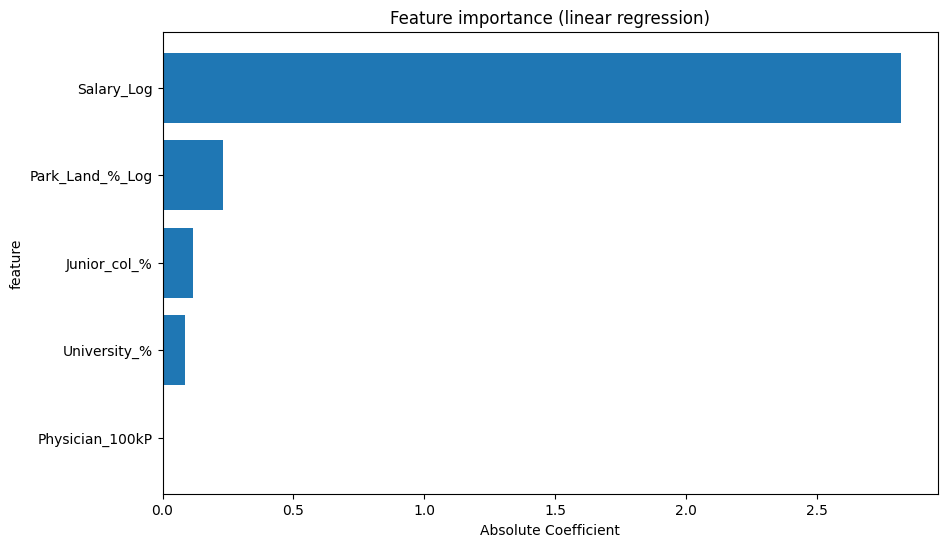

In [111]:
#Coefficient magintude ranking for linear regression
import pandas as pd
import matplotlib.pyplot as plt 
import joblib
#Plot feature importance
#Load the trained model
model=joblib.load("../models/model_v2.pkl")
#retrieve coefficients
coefficients=model.coef_
features=[
    'Junior_col_%', 'University_%', 'Salary_Log', 'Physician_100kP', 'Park_Land_%_Log'
]
#coefficient needs to be 1D 
coefficients=coefficients.flatten()
print(coefficients.shape)

#Combine in a dataframe for better readability
importance_df=pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})
importance_df["Absolute_Coefficient"]=importance_df["Coefficient"].abs()
print(importance_df)
#Sorting coefficients by order of magnitude for Dataframes
importance_df=importance_df.sort_values(by="Absolute_Coefficient", ascending=False)
print(importance_df)
#visualize feature importance using bar plot 
plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"], importance_df["Absolute_Coefficient"])
plt.xlabel("Absolute Coefficient")
plt.ylabel("feature")
plt.title("Feature importance (linear regression)")
plt.gca().invert_yaxis()
plt.show()

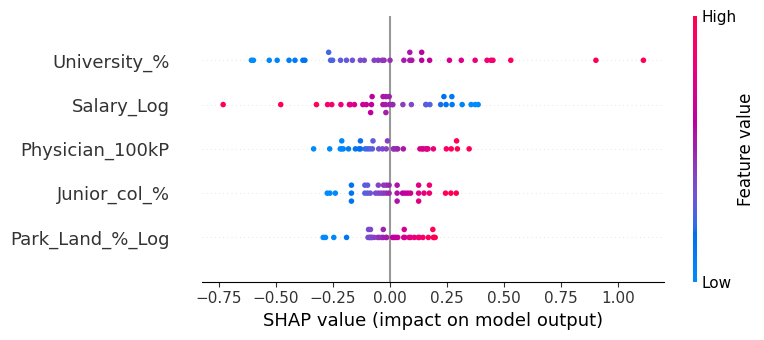

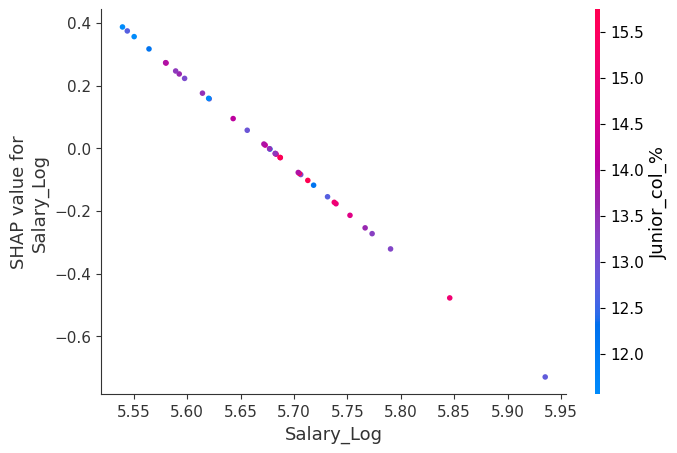

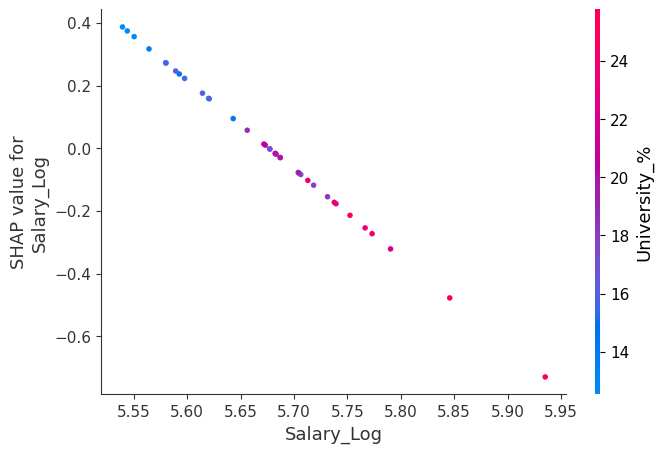

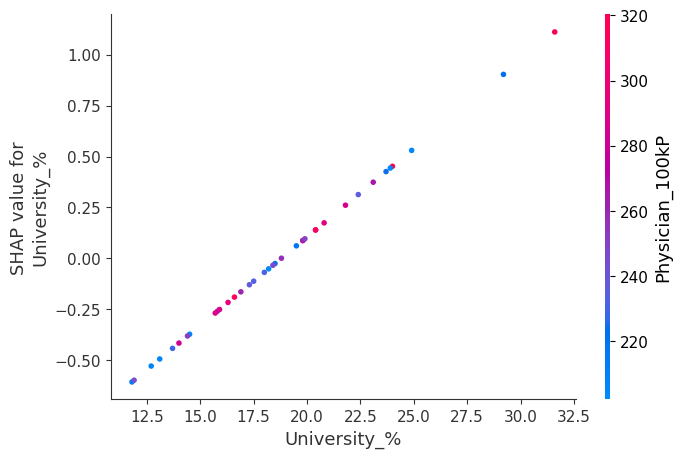

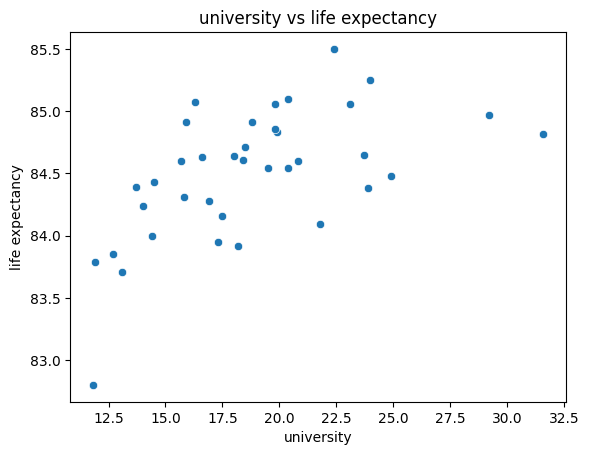

In [112]:
#SHAP
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
#explain de model prediction using SHAP
X_train=pd.read_excel("~/Library/CloudStorage/OneDrive-国立大学法人東海国立大学機構/Weekly_challenges/Data science and Analytics/Japan_Life_Expectency/data/processed/X_trainy_log.xlsx")
y_train=pd.read_excel("~/Library/CloudStorage/OneDrive-国立大学法人東海国立大学機構/Weekly_challenges/Data science and Analytics/Japan_Life_Expectency/data/processed/y_trainy.xlsx")
explainer=shap.Explainer(model, X_train)
shap_values=explainer(X_train)
#summary plot
shap.summary_plot(shap_values, X_train)

shap_values_array=shap_values.values
#SHAP dependance plot to visualize interactions along with the most interacting feature
shap.dependence_plot("Salary_Log", shap_values_array, X_train.values, feature_names=X_train.columns)
shap.dependence_plot("Salary_Log", shap_values_array, X_train.values, feature_names=X_train.columns, interaction_index="University_%")
shap.dependence_plot("University_%", shap_values_array, X_train.values, feature_names=X_train.columns)
#Verify your hypothesis
y_train=y_train.squeeze()
sns.scatterplot(x=X_train["University_%"], y=y_train)
plt.title("university vs life expectancy")
plt.xlabel("university")
plt.ylabel("life expectancy")
plt.show() 

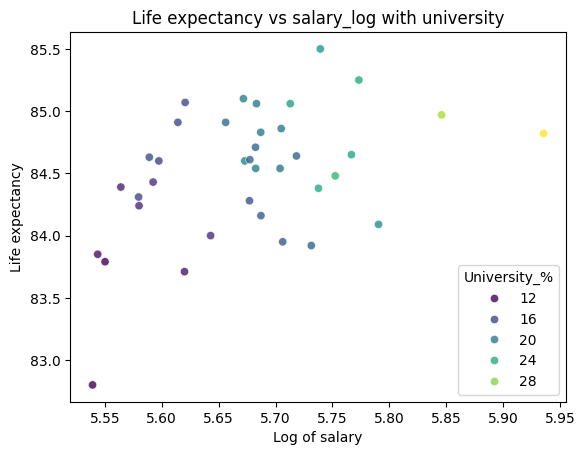

       Junior_col_%  University_%  Salary_Log  Physician_100kP  \
count     37.000000     37.000000   37.000000        37.000000   
mean      13.627027     18.789189    5.676502       253.621622   
std        1.200844      4.532769    0.085762        40.030982   
min       11.300000     11.800000    5.539301       177.800000   
25%       12.800000     15.800000    5.614222       224.400000   
50%       13.500000     18.400000    5.682389       250.100000   
75%       14.400000     20.800000    5.718343       287.100000   
max       16.100000     31.600000    5.935291       332.600000   

       Park_Land_%_Log  
count        37.000000  
mean          2.762285  
std           0.555852  
min           1.504077  
25%           2.415914  
50%           2.701361  
75%           3.157000  
max           3.618993  
Salary_Log
Low     29
High     8
Name: count, dtype: int64
University_%
Low     28
High     9
Name: count, dtype: int64
  Salary_bin Education_bin  Life_expectancy
0        Low    

/var/folders/67/30n6r04x5tv_vpf5gf2t8t_80000gn/T/ipykernel_97782/1209429619.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(['Salary_bin', 'Education_bin']).mean().reset_index()


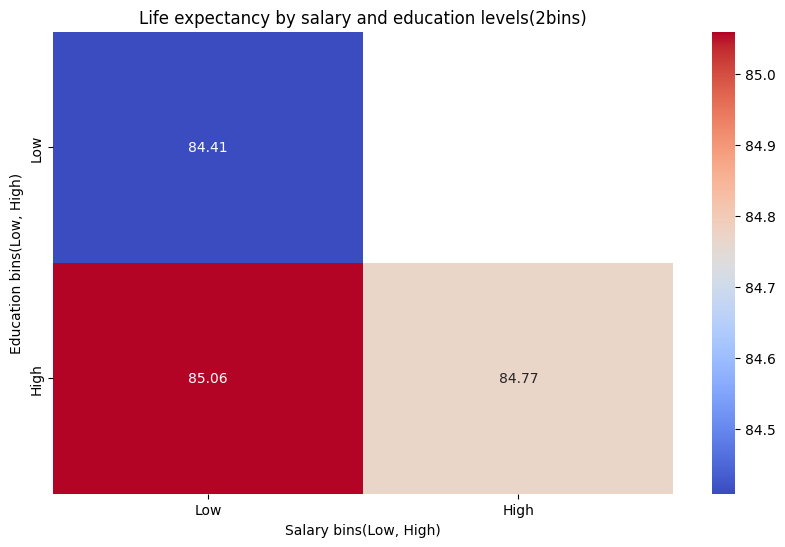

In [105]:
#Interpretation
#scatter plot: Salary vs life expectancy with university % as color
sns.scatterplot(x='Salary_Log', y=y_train, hue="University_%", palette='viridis', alpha=0.8, data=X_train)
plt.title('Life expectancy vs salary_log with university')
plt.xlabel('Log of salary')
plt.ylabel('Life expectancy')
plt.show()
#Heatmap: group data into 2 bins (High/Low) 
print(X_train.describe())
#Bin salary_log and university_% into 2 categories: Low, High
salary_bins=pd.cut(X_train['Salary_Log'], bins=2, labels=['Low', 'High'])
education_bins=pd.cut(X_train['University_%'], bins=2, labels=['Low', 'High'])
print(f"{salary_bins.value_counts()}\n{education_bins.value_counts()}")
#create a pivot table for heatmap
heatmap_data=pd.DataFrame({
    'Salary_bin': salary_bins,
    'Education_bin': education_bins,
    'Life_expectancy': y_train
}).groupby(['Salary_bin', 'Education_bin']).mean().reset_index()
print(heatmap_data)
#pivot data for heatmap
heatmap_pivot=heatmap_data.pivot(index='Education_bin', columns='Salary_bin', values='Life_expectancy')
#plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Life expectancy by salary and education levels(2bins)")
plt.xlabel('Salary bins(Low, High)')
plt.ylabel('Education bins(Low, High)')
plt.show()
missing_data=heatmap_data[(heatmap_data['Salary_bin']=='High')&(heatmap_data['Education_bin']=='Low')]
print(missing_data)


In [110]:
# Test binning with 2, 3, or 4 bins for Salary_Log
for bins in [2, 3, 4]:
    salary_bins = pd.cut(X_train['Salary_Log'], bins=bins, labels=['Bin ' + str(i) for i in range(1, bins + 1)])
    print(f"Binning with {bins} bins:")
    print(salary_bins.value_counts())

# Test binning for University_%
for bins in [2, 3, 4]:
    education_bins = pd.cut(X_train['University_%'], bins=bins, labels=['Bin ' + str(i) for i in range(1, bins + 1)])
    print(f"Binning with {bins} bins:")
    print(education_bins.value_counts())


Binning with 2 bins:
Salary_Log
Bin 1    29
Bin 2     8
Name: count, dtype: int64
Binning with 3 bins:
Salary_Log
Bin 2    21
Bin 1    14
Bin 3     2
Name: count, dtype: int64
Binning with 4 bins:
Salary_Log
Bin 2    17
Bin 1    12
Bin 3     6
Bin 4     2
Name: count, dtype: int64
Binning with 2 bins:
University_%
Bin 1    28
Bin 2     9
Name: count, dtype: int64
Binning with 3 bins:
University_%
Bin 1    19
Bin 2    16
Bin 3     2
Name: count, dtype: int64
Binning with 4 bins:
University_%
Bin 2    15
Bin 1    13
Bin 3     7
Bin 4     2
Name: count, dtype: int64


# Observations from feature_engineering
`Coef_magnitude`:
- `University_%`,`Junior_college_%`,`Physician_100Kp`,`Park_Land_%` have all positive coefficients so they impact `Life_expectancy` positively while `Salary` has a negative coefficient and therefore impacts `Life_expectancy` negatively.

`SHAP`: 
- `University_%` and `Salary` have the most significant impact on predicting `Life_expectancy` 
- Higher Values for `University_%`,`Physician_100Kp`,`Park_Land_%`Increases `Life_expectancy` while lower values Decrease it
- Higher and lower Values for `Junior_col_%` have little impact on `Life_expectancy`
- Higher values for `Salary` decrease `Life_expectancy` while Lower values Increase it. (May be due to confounding variables like stress so further investigation is needed)
- Higher `University_%`is correlated with higher `Salary`
- `Shap_dependance_plot` shows that areas with lower university completion and lower salaries have higher life expectancy (Blue dots)while areas with higher university completion and higher salaries (Red dots) have lower life expectancy
  * Hypothesis: Urban, high salaries areas may have more stress, sedentary unhealthy lifestyle.. while rural., low salary areas live and eat healthier and are less prone to stress (Correlation not causation further evidence is needed) suggesting a non linear relationship between life expectancy, salary and education 
  * Validation: 
    - Add regional feature (urban/ rural) to include in analysis and include stress metrics (Cluster prefectures by Rural/Urban category before performing a linear regression)
    - Data Binning: to identify the correlation between salary, education and life expectancy we segmented the data into Low/High bins using a heatmap dataframe. Data reveals that a higher education consistently improves life expectancy while salary has a mixed effect and a low salary high education yields the highest life expectancy possibly due to a healthier and less stressful lifestyle than people who have high salary jobs. Overall the data is too skewed towards one side over the other so its best to avoid binning.